//todo rename from Untitled to somethings else

# Project Pythia: GeoCAT-Comp
Welcome. 

## Who are and what is GeoCAT
GeoCAT is the Geoscience Community Analysis Toolkit. Note, it does not analyze the community, rather it is a community built set of analysis tools. 

Think of GeoCAT as a machine shop instead of a production line, lots of tools to modify or examine the data, but no predetermined outcome, you choose how to use which tools in which order. And hey, if you need another tool that isn't there, let us know and/or help us build it.

This Project Pythia presentation won't be able to cover every tool in GeoCAT, so my goal is to show some things I think are interesting with the hope that you become a part of the contributing community.

## Part one: Data Analysis tools
The next two sections will showcase a recently released signal processing toolset. 

Meteorological data are often noisy with overlapping signals of various strengths. And since I find fourier analysis handy for fingerprinting data components, I wrote a superset of functionality from NCL into python for abstracting away the process of decomposition, fintering and recomposing the data. 

In the next few code blocks, we'll show how to extract specific signals from meteorological data.

## Using a fourier filter on tidal data
This is from geocat-examples, it is a demonstration of a case in which a narrow high amplitude signal can be be removed from a dataset to see contributions from lower aplitude data. This tidal data is from Point Reyes California during the month of January 2020.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import geocat.datafiles as gdf
from geocat.comp import fourier_filter

In [16]:
# Open a netCDF data file using xarray default engine and load the data into xarrays
dataset = xr.DataArray(pd.read_csv(
    gdf.get("ascii_files/CO-OPS_9415020_wl.csv")))
xr_data = dataset.loc[:, 'Verified (ft)']

res*5 = 0.006720430107526883


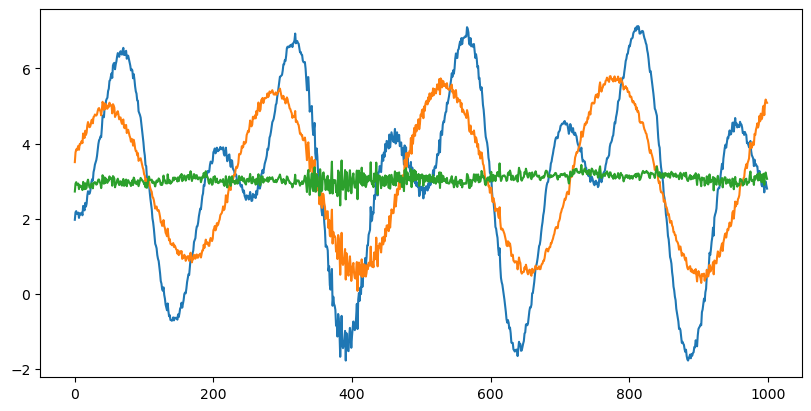

In [31]:
# Set points per hour
data_freq = 10

# Set tide cycle and frequency resolution
tide_freq1 = 1 / (1 * 12.4206) # lunar semi-diurnal
tide_freq2 = 1 / (2 * 12.4206) # lunar diurnal
res = data_freq / (len(xr_data)) 
print('res*5 = ' +str(res*5))

# Define cutoff_frequency_low and cutoff_frequency_high based on tide frequency
# each cutoff total width is 0.01 cycles/hour to cover the solar and eliptic semi-diurnal and diurnal components as well.
cflow1 = tide_freq1 - 0.005
cfhigh1 = tide_freq1 + 0.005
cflow2 = tide_freq2 - 0.005
cfhigh2 = tide_freq2 + 0.005

# Generate figure with 1 subplot and set its size (width, height) in inches
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8, 4), constrained_layout=True)

# Load signal data and plot it
no_tide = xr_data
ax.plot(no_tide[2000:3000])

# Plot filtered signal data using fourier_filter for the first set of cutoffs
no_tide = fourier_filter(no_tide,
                         data_freq,
                         cutoff_frequency_low=cflow1,
                         cutoff_frequency_high=cfhigh1,
                         band_block=True)
ax.plot(no_tide[2000:3000])

# Plot filtered signal data using fourier_filter for the second set of cutoffs
no_tide = fourier_filter(no_tide,
                         data_freq,
                         cutoff_frequency_low=cflow2,
                         cutoff_frequency_high=cfhigh2,
                         band_block=True)
ax.plot(no_tide[2000:3000])

# Show figure
plt.show()

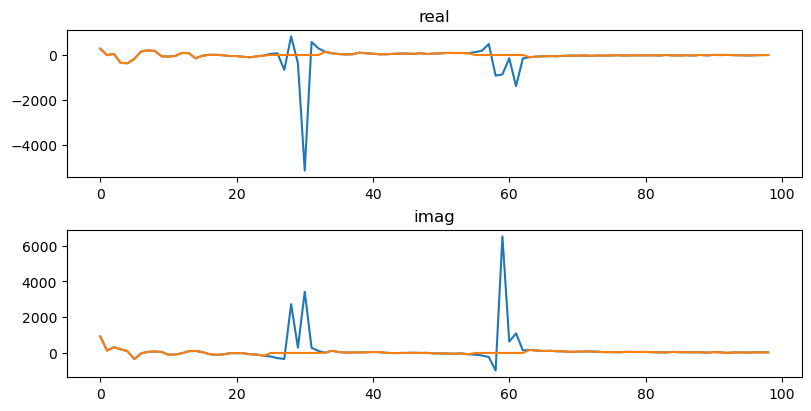

In [30]:
# Generate figure with 2 by 1 subplots and set its size (width, height) in inches
fig, axs = plt.subplots(2, 1, dpi=100, figsize=(8, 4), constrained_layout=True)

# Plot the real set of data utilizing NumPy's Fourier Transform function using both
# the original data and the fourier_filter applied to the second set of cutoffs
axs[0].set_title('real')
axs[0].plot(np.real(np.fft.fft(xr_data)[1:100]))
axs[0].plot(np.real(np.fft.fft(no_tide)[1:100]))

# Plot the imaginary set of data utilizing NumPy's Fourier Transform function using both
# the original data and the fourier_filter applied to the second set of cutoffs
axs[1].set_title('imag')
axs[1].plot(np.imag(np.fft.fft(xr_data)[1:100]))
axs[1].plot(np.imag(np.fft.fft(no_tide)[1:100]))

# Show figure
plt.show()

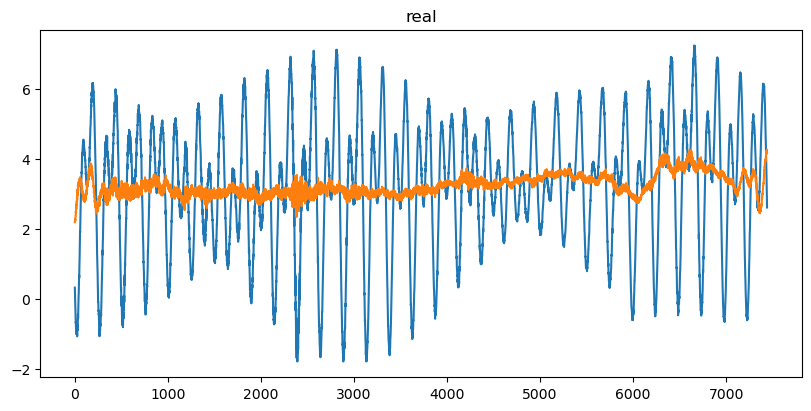

In [29]:
# Generate figure with 2 by 1 subplots and set its size (width, height) in inches
fig, axs = plt.subplots(1, 1, dpi=100, figsize=(8, 4), constrained_layout=True)

# Define start and end of data indices
start = 0
end = -1

# Plot the real and imaginary sets of data from the original and filtered data
axs.set_title('real')
axs.plot(np.real(xr_data)[start:end])
axs.plot(np.real(no_tide)[start:end])

# Show plot
plt.show()

# note the limited frequency removal at the edges of the graph, 
# this is due to 'ringing' from effectively using a boxcar window on the data
# there are ways to avoid that, but it's outside the scope of this, 
# and generally this is not needed, as it only has significant effect at the edges of the processed data. 
# 

## Extracting seasonally adjusted climate data from raw oberservations
Sea surface temperature in San Francisco bay, from a netcdf file.

In [20]:
dataset2 = xr.load_dataarray(gdf.get("netcdf_files/sfbay_2020_met.nc"))
dataset2

<xarray.DataArray (dim_0: 8784, dim_1: 4)>
array([['2020/01/01', '00:00', '12.3', '-'],
       ['2020/01/01', '01:00', '12.3', '-'],
       ['2020/01/01', '02:00', '12.2', '-'],
       ...,
       ['2020/12/31', '21:00', '11.6', '-'],
       ['2020/12/31', '22:00', '11.7', '-'],
       ['2020/12/31', '23:00', '11.7', '-']], dtype=object)
Coordinates:
  * dim_0    (dim_0) int32 0 1 2 3 4 5 6 ... 8777 8778 8779 8780 8781 8782 8783
  * dim_1    (dim_1) object 'Date' 'Time (GMT)' ... 'Conductivity (mS/cm)'

In [21]:
data2 = dataset2.loc[:,'Water Temp (°C)']
time2 = dataset2.loc[:,'Time (GMT)']


In [22]:
# this dataset used '-' to mark missing values so replace them with np.nan
data2[data2=='-']=np.nan
data2 = data2.astype(float)
# this is real data, check for nans
data2[np.isnan(data2)].dim_0

<xarray.DataArray 'dim_0' (dim_0: 2)>
array([1381, 5705], dtype=int32)
Coordinates:
  * dim_0    (dim_0) int32 1381 5705
    dim_1    <U15 'Water Temp (°C)'

In [23]:
# we've got nans, our nans aren't consecutive, we can interpolate them.
index = -1
for d2 in data2:
    index+=1
    if np.isnan(d2):
        data2[index]=(data2[index-1]+data2[index+1])/2 #interp nans
        print(index)

1381
5705


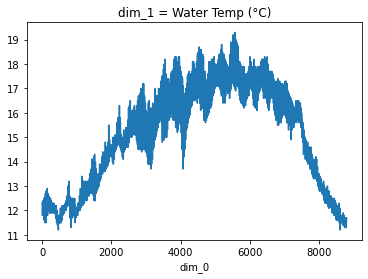

In [24]:
data2.plot()

## What is the underlying information upon which fourier filers act?
Fourier decomposition is transform from time series data to frequency series data. 
This is done either in the general case with a Discrete Fourier Transform, which has abritrary frequency resolution, but is computationally expensive at $O(n^2)$, or via the Fast Fourier Transform which works on data with a uniform sample rate, and has a frequency resolution of $(sampe rate)/(nnumber of samples)$, but has the advatage of being comparatively computationally inexpensive at $O(n*log(n))$.


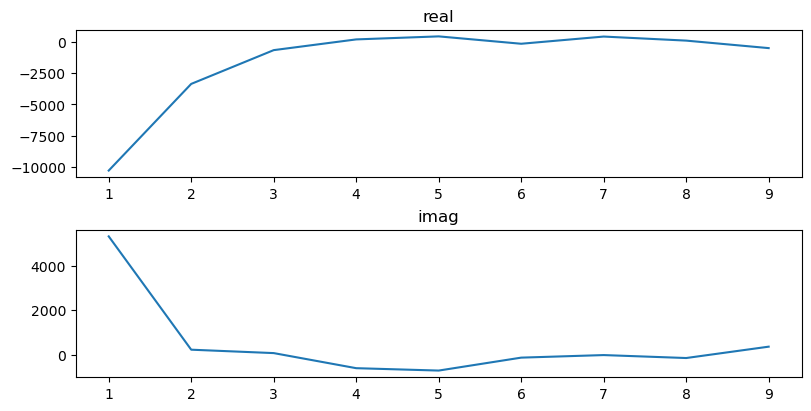

In [28]:
# Generate figure with 2 by 1 subplots and set its size (width, height) in inches
fig, axs = plt.subplots(2, 1, dpi=100, figsize=(8, 4), constrained_layout=True)

# Plot the real set of data utilizing NumPy's Fourier Transform function using both
# the original data and the fourier_filter applied to the second set of cutoffs
axs[0].set_title('real')
axs[0].plot(range(1,10),np.real(np.fft.fft(data2)[1:10]))

# Plot the imaginary set of data utilizing NumPy's Fourier Transform function using both
# the original data and the fourier_filter applied to the second set of cutoffs
axs[1].set_title('imag')
axs[1].plot(range(1,10),np.imag(np.fft.fft(data2)[1:10]))

# Show figure
plt.show()

### Data manipulation

We want to detrend the data, but we aren't sure what trends are in the dataset, and we don't want to remove something interesting, so we will plot the freqencies we intend to remove against our dataset before modifying our data. 

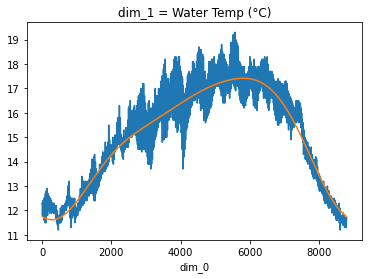

In [26]:
data_freq2 = 1 #points per hour
res2 = data_freq2/(len(data2)) #(fft resolution in cycles per hour)
cflow = res2*0 # steady state inclusive
cfhigh = res2*4 # up to 3 cycles per year exclusive (n-1)
blocked = fourier_filter(data2, 
                         data_freq2,
                         cutoff_frequency_low=cflow,
                         cutoff_frequency_high=cfhigh,
                         band_pass=True)
data2.plot()
blocked.plot()

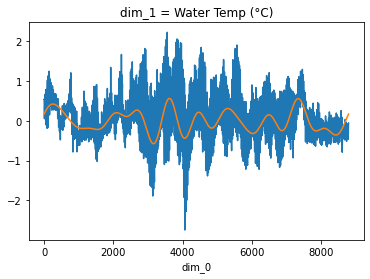

In [27]:
data_freq2 = 1 #points per hour
res2 = data_freq2/(len(data2)) #(fft resolution in cycles per hour)
cflow = res2*0 # lower bound zero cycles per year (inclusive)
cfhigh = res2*4 # Upper bound one cycles per year (exclusive)
detrended = fourier_filter(data2,
                           data_freq2,
                           cutoff_frequency_low=cflow,
                           cutoff_frequency_high=cfhigh,
                           band_block=True)
cflow = res2*4 # steady state inclusive
cfhigh = res2*13 # up to 12 cycles per year (n-1)
blocked = fourier_filter(data2, 
                         data_freq2,
                         cutoff_frequency_low=cflow,
                         cutoff_frequency_high=cfhigh,
                         band_pass=True)
detrended.plot()
blocked.plot()

## Regridding tools, data format tools
_vamp_



In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib import cm
from mpl_toolkits.axes_grid1 import AxesGrid

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.comp import linint2


ModuleNotFoundError: No module named 'geocat.viz'

In [ ]:
# Open a netCDF data file using xarray default engine and load the data
# into xarray.DataArrays
ds = xr.open_dataset(gdf.get('netcdf_files/sst.nc'))
sst = ds.TEMP[0, 0, :, :].chunk()
lat = ds.LAT[:]
lon = ds.LON[:]

In [ ]:
# Provide (output) interpolation grid
newlat = np.linspace(min(lat), max(lat), 24)
newlon = np.linspace(min(lon), max(lon), 72)

# Invoke `linint2` from `geocat.comp`
newsst = linint2(sst, newlon, newlat, icycx=False)

In [ ]:
# Generate figure and set its size (width, height) in inches
fig = plt.figure(figsize=(10, 8))

# Generate Axes grid using a Cartopy projection
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
axgr = AxesGrid(fig,
                111,
                axes_class=axes_class,
                nrows_ncols=(2, 1),
                axes_pad=0.7,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.5,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode

# Create a dictionary for common plotting options for both subplots
plot_options = dict(transform=projection,
                    cmap=cm.jet,
                    vmin=-30,
                    vmax=30,
                    levels=16,
                    extend='neither',
                    add_colorbar=False,
                    add_labels=False)

# Plot original grid and linint2 interpolations as two subplots
# within the figure
for i, ax in enumerate(axgr):

    # Plot contours for both the subplots
    if (i == 0):
        sst.plot.contourf(ax=ax, **plot_options)
        ax.set_title('Original Grid', fontsize=14, fontweight='bold', y=1.04)
    else:
        p = newsst.plot.contourf(ax=ax, **plot_options)
        ax.set_title('Regrid (to coarse) - linint2',
                     fontsize=14,
                     fontweight='bold',
                     y=1.04)

    # Add coastlines to the subplots
    ax.coastlines()

    # Use geocat.viz.util convenience function to add minor and major tick
    # lines
    gvutil.add_major_minor_ticks(ax)

    # Use geocat.viz.util convenience function to set axes limits & tick
    # values without calling several matplotlib functions
    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(-180, 180, 13),
                                     yticks=np.linspace(-60, 60, 5))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gvutil.add_lat_lon_ticklabels(ax, zero_direction_label=False)

# Add color bar and label details (title, size, etc.)
cax = axgr.cbar_axes[0]
cax.colorbar(p)
axis = cax.axis[cax.orientation]
axis.label.set_text(r'Temperature ($^{\circ} C$)')
axis.label.set_size(16)
axis.major_ticklabels.set_size(10)

plt.show()